No handles with labels found to put in legend.


Based on streamflow plots:
week 1 forecast: 170 cfs
week 2 forecast: 177 cfs
Weekly Forecasts: [223.72750000000002, 127.30571428571427, 258.6, 152.05714285714285, 107.97714285714287, 112.48571428571427, 181.1657142857143, 144.48000000000002, 142.9142857142857, 151.8, 150.6, 164.05714285714285, 170.31428571428572, 174.82857142857142, 186.45714285714286, 190.54285714285714]


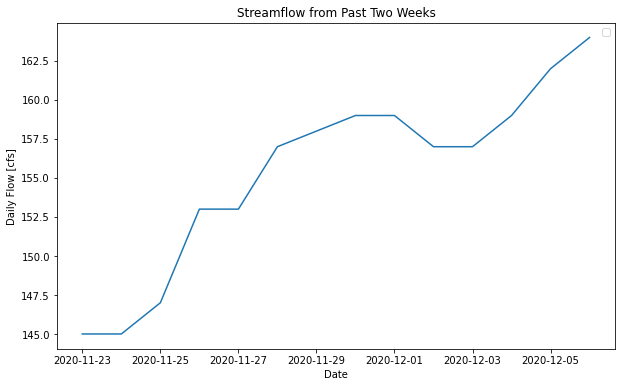

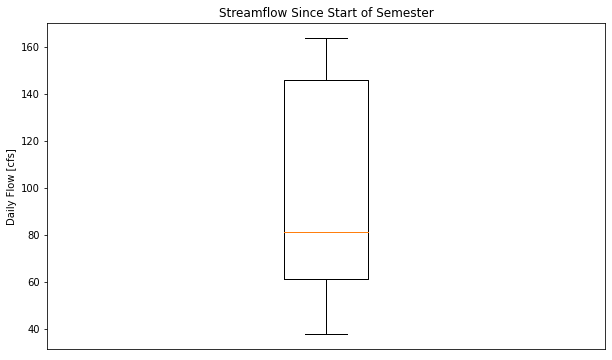

In [2]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def getForecastDates():
    """Get dataframe of forecast dates from csv file.

    -------------------------------------------------
    Parameters: None

    -------------------------------------------------
    Outputs:
    forecast dates = dataframe
                     contains columns with start and end
                     dates split up into
                     year, month, and day
    """
    #  Read in the forecast dates for each week from csv
    forecast_dates = pd.read_csv("Seasonal_Forecast_Dates.csv", skiprows=1,
                                 names=['week', 'start_date', 'end_date'])
    forecast_dates[["start_year", "start_month", "start_day"]] \
        = forecast_dates["start_date"].\
        astype(str).str.split("-", expand=True)

    # split forecast start and end dates into year, month, and day
    forecast_dates['start_year'] = forecast_dates['start_year'].astype(int)
    forecast_dates['start_month'] = forecast_dates['start_month'].astype(int)
    forecast_dates['start_day'] = forecast_dates['start_day'].astype(int)
    forecast_dates[["end_year", "end_month", "end_day"]] \
        = forecast_dates["end_date"].\
        astype(str).str.split("-", expand=True)
    forecast_dates['end_year'] = forecast_dates['end_year'].astype(int)
    forecast_dates['end_month'] = forecast_dates['end_month'].astype(int)
    forecast_dates['end_day'] = forecast_dates['end_day'].astype(int)

    return forecast_dates


# %%
# Plot data for 2 week streamflow forecast

# Read the data into a pandas dataframe
url_usgs = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on' \
           '&format=rdb&site_no=09506000&referred_module=sw' \
           '&period=&begin_date=1989-01-01&end_date=2020-12-06'

data = pd.read_table(url_usgs, skiprows=30, names=['agency_cd', 'site_no',
                                                   'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

# Expand the dates to year month day
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).dayofweek
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = data.resample("W", on='datetime').mean()

# Plot daily streamflow
fig, ax = plt.subplots()
ax.plot(data['datetime'].tail(14), data['flow'].tail(14), color='C0')
ax.set(title="Streamflow from Past Two Weeks",
       xlabel="Date", ylabel="Daily Flow [cfs]")
ax.legend()
fig.set_size_inches(10, 6)


# Plot year to date streamflow
fig, ax = plt.subplots()
ax.boxplot(data['flow'].tail(92))
ax.set(title="Streamflow Since Start of Semester",
       ylabel="Daily Flow [cfs]")
ax.xaxis.set_visible(False)
fig.set_size_inches(10, 6)

print('Based on streamflow plots:')
print('week 1 forecast: 170 cfs')
print('week 2 forecast: 177 cfs')


# %%
# Prepare 16 week forecasts

# get data from beginning of semester
url_usgs_16wk = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on' \
           '&format=rdb&site_no=09506000&referred_module=sw' \
           '&period=&begin_date=1989-01-01&end_date=2020-08-29'
data_16wk = pd.read_table(url_usgs_16wk, skiprows=30, names=['agency_cd',
                                                             'site_no',
                                                             'datetime',
                                                             'flow', 'code'],
                          parse_dates=['datetime'])

# Expand the dates to year month day and set them as integers
data_16wk[["year", "month", "day"]] = data_16wk["datetime"].\
                                 astype(str).str.split("-", expand=True)
data_16wk['year'] = data_16wk['year'].astype(int)  # year integer
data_16wk['month'] = data_16wk['month'].astype(int)  # month integer
data_16wk['day'] = data_16wk['day'].astype(int)  # day integer

# get annual average streamflow
year_means = np.zeros((32, 2))
for j in range(1989, 2021):
    year_means[j-1989, 0] = j
    year_means[j-1989, 1] = data_16wk[data_16wk.year == j].flow.mean()

# find the five driest years on record using nsmallest
driest = pd.DataFrame(year_means, columns=['year', 'mean']).\
         nsmallest(5, 'mean')
driest.index = range(5)
driest['year'] = driest['year'].astype(int)

# make a dataframe that only contains data from the driest years
dry_years_data = data_16wk[(data_16wk.year == driest.year[0]) |
                           (data_16wk.year == driest.year[1]) |
                           (data_16wk.year == driest.year[2]) |
                           (data_16wk.year == driest.year[3]) |
                           (data_16wk.year == driest.year[4])
                           ]

forecast_dates = getForecastDates()

# initialize list for weekly forecasts
forecasts = []

# go through each week and get the means for each week
for i in range(16):

    # if the forecast week starts and ends in different months
    if (forecast_dates.start_month[i] != forecast_dates.end_month[i]):
        # set the date of the last day of the month
        if(forecast_dates.start_month[i] == 8):
            last_day = 31
        if(forecast_dates.start_month[i] == 9):
            last_day = 30
        if(forecast_dates.start_month[i] == 10):
            last_day = 31
        if(forecast_dates.start_month[i] == 11):
            last_day = 30
        # take average of all dates within the forecast week during dry years
        wk_mean = dry_years_data[((dry_years_data.month ==
                                   forecast_dates.start_month[i]) &
                                 (dry_years_data.day >=
                                  forecast_dates.start_day[i]) &
                                 (dry_years_data.day <= last_day)) |
                                 ((dry_years_data.month ==
                                  forecast_dates.end_month[i]) &
                                 (dry_years_data.day >= 1) &
                                 (dry_years_data.day <=
                                  forecast_dates.end_day[i]))].flow.mean()
        # add weekly mean to forecast lists
        forecasts.append(wk_mean)

    # if the forecast week starts and ends in the same month
    else:
        # take average of all dates within forecast week during dry years
        wk_mean = dry_years_data[(dry_years_data.month ==
                                  forecast_dates.start_month[i]) &
                                 (dry_years_data.day >=
                                  forecast_dates.start_day[i]) &
                                 (dry_years_data.day <=
                                  forecast_dates.end_day[i])].flow.mean()
        # add weekly mean to forecast lists
        forecasts.append(wk_mean)

print('Weekly Forecasts:', forecasts)

# %%
